<a href="https://colab.research.google.com/github/ThatGuyDV/CNNapproches/blob/master/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import getpass

In [2]:
!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade
import os
credentials = {"username":"dv1453","key":getpass.getpass()}
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]

  Cloning https://github.com/Kaggle/kaggle-api.git to /tmp/pip-req-build-ax3mqdoy
  Running command git clone -q https://github.com/Kaggle/kaggle-api.git /tmp/pip-req-build-ax3mqdoy
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=78385 sha256=5607d4e85e2459ab3ef0f24555f3268ee75beb417e48dfee44ac246ceee51e0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-fh1fyq_z/wheels/2f/2c/1d/18a38a6b617c2c338bdcbf409f3ccc2452799db7dca965d475
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
··········


In [6]:
!kaggle datasets download -d alxmamaev/flowers-recognition --force

 95% 427M/450M [00:03<00:00, 75.8MB/s]
100% 450M/450M [00:03<00:00, 119MB/s] 


In [7]:
%%capture
!unzip flowers-recognition.zip

In [8]:
data_dir = '/content/flowers/flowers'

In [9]:
import os 
Labels = os.listdir(data_dir)
Labels

['rose', 'tulip', 'daisy', 'sunflower', 'dandelion']

In [10]:
import torch
import numpy as np
from torch.utils.data import DataLoader,random_split
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

In [11]:
trans =transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.3),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean =[0.485,0.456,0.406], std = [0.229,0.224,0.225])
])

In [12]:
data = ImageFolder(data_dir, transform = trans)

In [13]:
train_size = round(0.85 * len(data))
test_size = len(data)- train_size
print('trian size:', train_size, '\n test size:', test_size)

trian size: 3675 
 test size: 648


In [14]:
train_data, test_data = random_split(data, [train_size, test_size] )

In [15]:
batch_size = 16

In [16]:

# PyTorch data loaders
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(test_data, batch_size*2, num_workers=3, pin_memory=True)

In [17]:
from torchvision.utils import make_grid

def show_batch(dl):
    x =[]
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        for label in labels:
          x.append(Labels[label])
        print(x)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['rose', 'dandelion', 'dandelion', 'dandelion', 'tulip', 'sunflower', 'daisy', 'tulip', 'dandelion', 'tulip', 'sunflower', 'daisy', 'sunflower', 'tulip', 'rose', 'sunflower']


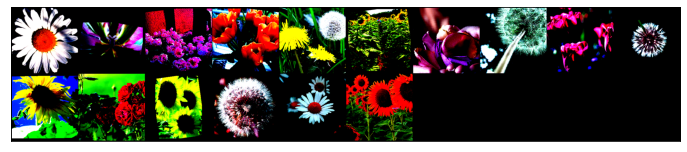

In [18]:
show_batch(train_dl)

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [23]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512*8*8, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [24]:
model = to_device(ResNet9(3, 5), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    loss = F.cross_entropy(out, labels)
    print(loss)
    acc = accuracy(out, labels)
    print(acc)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 256, 256])
tensor(1.9587, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0625)
out.shape: torch.Size([16, 5])
out[0]: tensor([2.6722, 0.0753, 0.2386, 1.9738, 2.0128], device='cuda:0',
       grad_fn=<SelectBackward>)


In [27]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.2068452388048172, 'val_loss': 1.6091010570526123}]

In [28]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [31]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00394, train_loss: 6.0218, val_loss: 6.7254, val_acc: 0.2723



Epoch [1], last_lr: 0.00935, train_loss: 4.1474, val_loss: 2.9408, val_acc: 0.4137



Epoch [2], last_lr: 0.00972, train_loss: 2.1297, val_loss: 4.2686, val_acc: 0.4375



Epoch [3], last_lr: 0.00812, train_loss: 2.3403, val_loss: 1.8603, val_acc: 0.4583



Epoch [4], last_lr: 0.00556, train_loss: 1.5797, val_loss: 1.9684, val_acc: 0.4926



Epoch [5], last_lr: 0.00283, train_loss: 1.3248, val_loss: 1.4069, val_acc: 0.5491



Epoch [6], last_lr: 0.00077, train_loss: 1.1858, val_loss: 1.1782, val_acc: 0.5729



Epoch [7], last_lr: 0.00000, train_loss: 1.0766, val_loss: 1.1098, val_acc: 0.5714
CPU times: user 13min 33s, sys: 11min 21s, total: 24min 55s
Wall time: 26min 9s


In [32]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

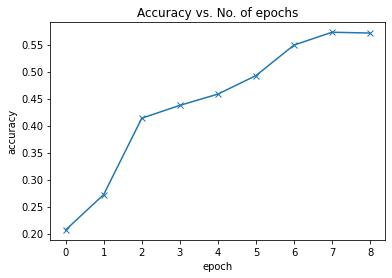

In [33]:
plot_accuracies(history)

In [34]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

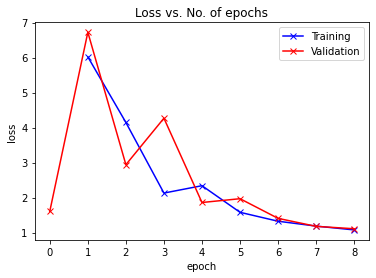

In [35]:
plot_losses(history)

In [36]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

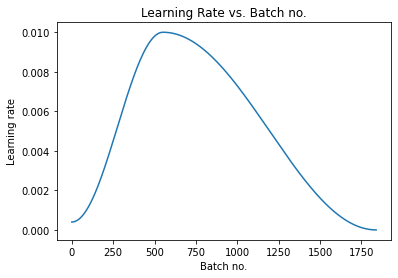

In [37]:
plot_lrs(history)

In [38]:
epochs = 8
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [39]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00039, train_loss: 1.0722, val_loss: 1.1425, val_acc: 0.5595



Epoch [1], last_lr: 0.00094, train_loss: 1.3972, val_loss: 1.7414, val_acc: 0.5238



Epoch [2], last_lr: 0.00097, train_loss: 1.6856, val_loss: 1.8085, val_acc: 0.5476



Epoch [3], last_lr: 0.00081, train_loss: 1.3060, val_loss: 2.0887, val_acc: 0.4821



Epoch [4], last_lr: 0.00056, train_loss: 1.1636, val_loss: 1.1564, val_acc: 0.5610



Epoch [5], last_lr: 0.00028, train_loss: 1.0240, val_loss: 1.0279, val_acc: 0.6190



Epoch [6], last_lr: 0.00008, train_loss: 0.9157, val_loss: 1.0089, val_acc: 0.6250



Epoch [7], last_lr: 0.00000, train_loss: 0.8747, val_loss: 0.9708, val_acc: 0.6473
CPU times: user 13min 31s, sys: 11min 19s, total: 24min 51s
Wall time: 26min 7s


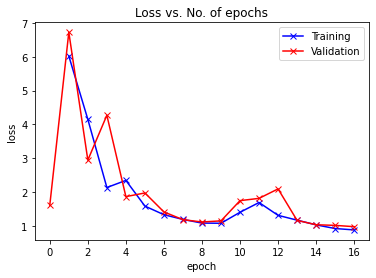

In [40]:
plot_losses(history)

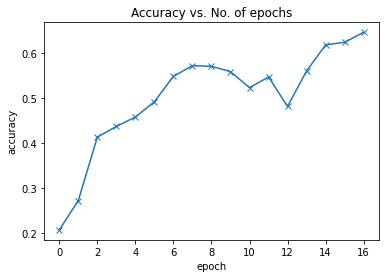

In [41]:
plot_accuracies(history)

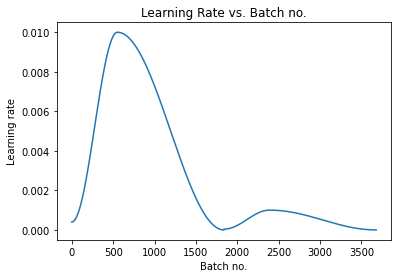

In [42]:
plot_lrs(history)

In [ ]:
%%time
history += fit_one_cycle(5, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)